# Identifying Habitable Exoplanets using Machine Learning
## Data Science Capstone Project of BBM467, 2022 Fall

#### Hikmet Güner, Deniz Erkin Kasaplı
#### 21946179, 21946328

Clustering exoplanets using machine learning in order to gather insight about potentially habitable planets outside of our solar system.
Considering the fact that even the closest planets outside of the solar system are unreachable, there is no way to classify a planet as habitable or not with accuracy. However, there are some key elements which are considered necessary for habitability. The aim of this project is to gather insight of how grouping planets, without making any habitability indicing calculations, could affect filtering based on habitability. The dataset used for this project is directly fetched from NASA's exoplanet archive, which will be clustered for further analysis. The results could be utilized to filter out false positives, saving time and resources which would be spent on those planets otherwise.


## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Describe the problem here. What are the questions you are trying to solve?

Considering the fact that the tools used to identify exoplanets are biased, it seems plausible to begin the analysis without any prior knowledge of the planet, where the algorithm only groups planets that correleate. Then, from these correleations, more insight could be gained on placing key plantes which are known to be habitable or close to be habitable, such as Earth and Mars. However, these results should not be taken at face value, they exist simply to filter unwanted planets or false positives as much as possible.

Imports required for the notebook

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import math

from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import ConvexHull
from scipy import interpolate
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity
from sklearn.metrics.cluster import rand_score
from sklearn.decomposition import PCA

Reading the data, Supressing chained assignment warning, since chained assignment works six to seven times faster, supressing future warnings

In [83]:
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv("exoplanets.csv",header=0, index_col=0)
pd.set_option('mode.chained_assignment', None)

## Data Understanding<a class="anchor" id="data_understanding"></a>

The dataset used is directly from NASA's exoplanet archive, which the user "SATHYANARAYAN RAO" on Kaggle has compiled and created a comma-separated value (.csv) version of it.

The dataset has fields about planetary attributes, stellar attributes and star system based attributes. Some of the fields have labels, some of them have hyper links but the majority of them are scalar. Further analysis can be found in the column analysis spreadsheet

The dataset could be reached from the link <a href=https://www.kaggle.com/datasets/sathyanarayanrao89/nasa-exoplanetary-system>here</a> ( <a href="exoplanets.csv">.csv format</a>)

You can reach the column analysis spreadsheet from <a href="columns.xlsx">here</a>

In [84]:
df.head(10)

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 Com b,11 Com,0,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-07-23,2011-08,2014-07-23
2,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2011-08,2014-07-23
3,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14
5,14 And b,14 And,0,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-07-23,2011-08,2014-07-23
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20
8,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2003-01,2014-08-21
9,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2018-04-25,2008-04,2014-08-21


## Data Preparation<a class="anchor" id="data_preparation"></a>

First, rows missing over %50 of their data will be dropped, since their quantity is a fraction of the data the impact is negligible.

Then, the columns that are not useful for the model will be dropped, refer to [Data Understanding](#data_understanding) for the details about the columns.

Finally an analysis of null values within the remaining data will be conducted. The KNN imputation method seems to consistently fill the missing data based on minimal changes of data variety before and after the imputation.

### Required function declerations

#### Getting the amount of missing columns per row

In [85]:
def get_empty_col(row_index):
    total_nan = 0
    for col in df.columns:
        if pd.isna(df[col][row_index]):
            total_nan += 1
    return total_nan

#### Getting the histogram, KDE and PDF plotted of a plot

In [86]:
def get_cols_info():
    n_col = 6
    fig, axes = plt.subplots(nrows=(len(df.columns) // n_col), ncols=n_col, figsize=(18,18))
    ax_index = 0
    fig.suptitle(f'Distribution of Columns Visualized')
    for col in df.columns:
        sample = df[col].sort_values()
        #attributes
        mean = sample.mean()
        std = sample.std()
        col_max = sample.max()
        col_min = sample.min()
        sem = sample.sem()
        sample -= mean 
         
        pdf = stats.norm.pdf(sample,mean,std)

        ax = axes[ax_index // n_col][ax_index % n_col]
        #normalize plot
        ax.hist(sample, bins=20, density=True, label="Data", color='gray')
        ax.plot(sample, pdf, 'r-', label="PDF")                   
        sns.kdeplot(data=sample,ax=ax, label = 'KDE')                                       

        ax.legend(loc='best')

        x_ticks = np.arange(-4*std, 4.1*std, std)                                  
        x_labels = [f"{i}std" for i in range(-4,5)]    
        ax.grid(True, alpha=0.3, linestyle="--")
        ax.set_title(col)
        ax_index += 1
        #box plot
    fig.tight_layout()
    df.loc[:,~df.columns.str.contains('err') & ~df.columns.str.contains('flag')].plot(kind='box',title='Box Plot', showfliers = False, figsize= (22,6))

### Rows

#### Find the number of empty columns per row, append it to the dataframe

In [87]:
df['empty_col_count'] = 0
for i in df.index:
    df['empty_col_count'][i] = get_empty_col(i)

#### Sort rows by number of empty columns and last update, filter out the old ones if there are no missing columns in the updated entries

In [88]:
df = df.sort_values(['empty_col_count','rowupdate'], ascending=[True,True]).drop_duplicates('pl_name').sort_index()

#### Checking the maximum and the minimum amount of missing columns, comparing it to the total amount of columns

In [89]:
print('Max:\t', df['empty_col_count'].max())
print('Min:\t',df['empty_col_count'].min())
print('Total:\t',len(df.columns))

Max:	 61
Min:	 0
Total:	 93


#### Dropping rows missing over 50% of columns

In [90]:
df = df[df['empty_col_count'] < 50]
df.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,empty_col_count
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14,16
4,11 UMi b,11 UMi,0,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-04-25,2009-10,2014-05-14,16
6,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14,24
7,14 Her b,14 Her,0,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2021-09-20,2021-05,2021-09-20,17
19,16 Cyg B b,16 Cyg B,0,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,4.651,0.016,-0.016,6.06428,0.000603,-0.000603,2018-04-25,2007-09,2014-09-18,17


#### Appending Earth, Venus and Mars to the data for later comparison, this is done after the row dropping due to high amount of missing data

The data is also reindexed

In [91]:
earth = {'pl_name':'Earth','hostname':'Sol','sy_snum':1,'sy_pnum': 8,'pl_orbper': 365,'pl_orbsmax': 1,'pl_rade': 1,'pl_bmasse': 1,'pl_bmassj': 0.0031,'pl_orbeccen': 0.0167,'pl_eqt': 255,'ttv_flag':1 ,'st_teff': 5780,'st_rad':1,'st_mass': 1,'st_met': 0.012,'st_logg': 4.438}
venus = {'pl_name':'Venus','hostname':'Sol','sy_snum':1,'sy_pnum': 8,'pl_orbper': 225,'pl_orbsmax': 0.723,'pl_rade': 0.949,'pl_bmasse': 0.815,'pl_bmassj': 0.00256,'pl_orbeccen': 0.006772,'pl_eqt': 226,'ttv_flag':1,'st_teff': 5780,'st_rad':1,'st_mass': 1,'st_met': 0.012,'st_logg': 4.438}
mars = {'pl_name':'Mars','hostname':'Sol','sy_snum':1,'sy_pnum': 8,'pl_orbper': 687,'pl_orbsmax': 1.524,'pl_rade': 0.532,'pl_bmasse': 0.107,'pl_bmassj': 0.000338,'pl_orbeccen': 0.093,'pl_eqt': 210,'ttv_flag':1,'st_teff': 5780,'st_rad':1,'st_mass': 1,'st_met': 0.012,'st_logg': 4.438}
jupiter = {'pl_name':'Jupiter','hostname':'Sol','sy_snum':1,'sy_pnum': 8,'pl_orbper': 4386,'pl_orbsmax': 5.204,'pl_rade': 11.209,'pl_bmasse': 317.83,'pl_bmassj': 1,'pl_orbeccen': 0.048775 ,'pl_eqt': 109.9,'ttv_flag':1,'st_teff': 5780,'st_rad':1,'st_mass': 1,'st_met': 0.012,'st_logg': 4.438}
df = df.append(earth,ignore_index=True)
df = df.append(venus,ignore_index=True)
df = df.append(mars,ignore_index=True)
df = df.append(jupiter,ignore_index=True)
df.tail()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate,empty_col_count
4930,xi Aql b,xi Aql,1.0,1,1,Radial Velocity,2007.0,Okayama Astrophysical Observatory,Published Confirmed,0.0,...,2.171,0.22,-0.22,4.42501,0.003837,-0.003837,2014-05-14,2008-06,2014-05-14,29.0
4931,Earth,Sol,NaN,1,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4932,Venus,Sol,NaN,1,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4933,Mars,Sol,NaN,1,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4934,Jupiter,Sol,NaN,1,8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Columns

#### Initializing drop columns list, filling it with columns that are indexed 4 or 0 in the column analysis spreadsheet

In [92]:
drop_columns = [
    'default_flag',
    'discoverymethod',
    'disc_year',
    'disc_facility',
    'soltype',
    'pl_controv_flag',
    'pl_refname',
    'sy_refname',
    'st_refname',
    'rastr',
    'ra',
    'decstr',
    'dec',
    'st_metratio',
    'pl_pubdate',
    'releasedate',
    'pl_radjlim',
    'pl_bmassprov',
    'pl_bmasselim',
    'pl_bmassjlim',
    'pl_orbperlim',
    'pl_orbsmaxlim',
    'pl_radelim',
    'pl_orbeccenlim',
    'pl_insollim',
    'pl_eqtlim',
    'st_tefflim',
    'st_radlim',
    'st_masslim',
    'st_metlim',
    'st_metratio',
    'st_logglim',
    'pl_bmasseerr2',
    'pl_bmassjerr2',
    'pl_orbsmaxerr2',
    'st_tefferr2',
    'st_raderr2',
    'st_masserr2',
    'st_meterr2',
    'st_loggerr2',
    'sy_vmagerr2',
    'sy_kmagerr2',
    'sy_gaiamagerr2',
    'pl_radeerr2',
    'pl_orbpererr2',
    'pl_insolerr2',
    'sy_disterr2',
    'empty_col_count'
]

#### Coulms with data missing over 70%, will be dropped

In [93]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if(na_ratio > 0.7):
        print(f"{name:<16} {na_ratio*100:.3f}%")
        drop_columns.append(name)

pl_radjerr1      70.071%
pl_radjerr2      70.071%
pl_orbeccenerr1  75.380%
pl_orbeccenerr2  75.380%
pl_eqterr1       78.419%
pl_eqterr2       78.419%
st_spectype      78.095%


#### Dropping columns

In [94]:
df = df.drop(columns=drop_columns)
df.head(10)

,pl_name,hostname,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,...,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1,rowupdate
0,11 Com b,11 Com,2,1,326.0300,0.3200,1.290,0.050,NaN,NaN,...,0.10,93.1846,1.92380,4.72307,0.023,2.282,0.346,4.44038,0.003848,2014-05-14
1,11 UMi b,11 UMi,1,1,516.2200,3.2500,1.540,0.070,NaN,NaN,...,0.15,125.3210,1.97650,5.01300,0.005,1.939,0.270,4.56216,0.003903,2018-04-25
2,14 And b,14 And,1,1,185.8400,0.2300,0.830,NaN,NaN,NaN,...,0.07,75.4392,0.71400,5.23133,0.023,2.331,0.240,4.91781,0.002826,2014-05-14
3,14 Her b,14 Her,1,2,1766.4100,0.6700,2.830,0.041,NaN,NaN,...,0.03,17.9323,0.00730,6.61935,0.023,4.714,0.016,6.38300,0.000351,2021-09-20
4,16 Cyg B b,16 Cyg B,3,1,799.5000,0.6000,1.680,0.030,NaN,NaN,...,0.10,21.1397,0.01100,6.21500,0.016,4.651,0.016,6.06428,0.000603,2018-04-25
5,17 Sco b,17 Sco,1,1,578.3800,2.0100,1.450,0.020,NaN,NaN,...,0.04,124.9530,2.59000,5.22606,0.023,2.094,0.244,4.75429,0.005055,2021-10-25
6,18 Del b,18 Del,2,1,993.3000,3.2000,2.600,NaN,NaN,NaN,...,0.06,76.2220,0.62170,5.51048,0.023,3.366,0.204,5.27476,0.002654,2014-05-14
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524,1,1,NaN,NaN,330.000,NaN,NaN,NaN,...,0.14,139.1350,1.33200,12.61800,0.069,8.916,0.021,12.05720,0.002275,2015-04-01
8,24 Boo b,24 Boo,1,1,30.3506,0.0078,0.190,0.012,NaN,NaN,...,0.10,95.9863,0.63685,5.59000,0.001,3.159,0.280,5.33390,0.002000,2018-04-25
9,24 Sex b,24 Sex,1,2,452.8000,2.1000,1.333,0.004,NaN,NaN,...,0.10,72.0691,0.68540,6.45350,0.023,4.285,0.016,6.20374,0.000498,2014-05-14


### Null Value Handling

#### Columns with missing data percentage over 30%, lower than 70%, will be filled, these are separeted for gathering insight

In [95]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio > 0.3:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbsmaxerr1   58.298%
pl_radj          69.970%
pl_bmasse        60.547%
pl_bmasseerr1    63.121%
pl_bmassj        60.547%
pl_bmassjerr1    63.141%
pl_insol         41.033%
pl_insolerr1     41.499%


#### Columns with missing data percentage lower than 30%, will be filled

In [96]:
for name, val in df.items():
    na_ratio =  val.isnull().sum() / len(val)
    if na_ratio < 0.3 and na_ratio != 0:
        print(f"{name:<16} {na_ratio*100:.3f}%")

pl_orbper        1.317%
pl_orbpererr1    2.229%
pl_orbsmax       6.768%
pl_rade          20.385%
pl_radeerr1      20.567%
pl_orbeccen      14.711%
pl_eqt           27.943%
st_teff          2.776%
st_tefferr1      4.073%
st_rad           5.431%
st_raderr1       6.322%
st_mass          0.608%
st_masserr1      3.343%
st_met           7.254%
st_meterr1       9.949%
st_logg          7.011%
st_loggerr1      7.822%
sy_dist          2.270%
sy_disterr1      4.255%
sy_vmag          0.892%
sy_vmagerr1      0.952%
sy_kmag          0.932%
sy_kmagerr1      1.499%
sy_gaiamag       1.763%
sy_gaiamagerr1   1.763%
rowupdate        0.101%


#### Before scaling, check if each data is suitable for scaling

In [97]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4935 entries, 0 to 4934
Columns: 39 entries, pl_name to rowupdate
dtypes: float64(33), int64(3), object(3)
memory usage: 1.5+ MB


#### Identify non-scalar columns

In [98]:
df.select_dtypes(object).value_counts()

pl_name       hostname    rowupdate 
11 Com b      11 Com      2014-05-14    1
Kepler-299 b  Kepler-299  2014-11-18    1
Kepler-300 b  Kepler-300  2014-11-18    1
Kepler-30 d   Kepler-30   2014-05-14    1
Kepler-30 c   Kepler-30   2014-05-14    1
                                       ..
KELT-21 b     KELT-21     2018-02-01    1
KELT-20 b     KELT-20     2019-12-02    1
KELT-2 A b    KELT-2 A    2019-03-18    1
KELT-19 A b   KELT-19 A   2018-01-08    1
xi Aql b      xi Aql      2014-05-14    1
Length: 4930, dtype: int64

#### Transfer said columns to another dataframe called label_df for further labelization if necessary, drop rows used to remove duplicates as well

In [99]:
label_df = df[['pl_name','hostname']]
df = df.drop(['pl_name','hostname','rowupdate'], axis=1)
label_df.head()

,pl_name,hostname
0,11 Com b,11 Com
1,11 UMi b,11 UMi
2,14 And b,14 And
3,14 Her b,14 Her
4,16 Cyg B b,16 Cyg B


In [100]:
habitable_array = ["TOI 700 d", "Kepler-1649c", "Proxima Centauri b"]
for i in habitable_array:
    for j in label_df["pl_name"]:
        if i == j:
            print(i)

In [101]:
#tau Boo b non habitable exoplanet in torch zone minimum mass is over 4 times of Jupiter
#Trappist-1 g is an exoplanet in habitable zone of its star


Check How much loss will occur without inputation

In [102]:
df.isnull().sum()

sy_snum              0
sy_pnum              0
pl_orbper           65
pl_orbpererr1      110
pl_orbsmax         334
pl_orbsmaxerr1    2877
pl_rade           1006
pl_radeerr1       1015
pl_radj           3453
pl_bmasse         2988
pl_bmasseerr1     3115
pl_bmassj         2988
pl_bmassjerr1     3116
pl_orbeccen        726
pl_insol          2025
pl_insolerr1      2048
pl_eqt            1379
ttv_flag             0
st_teff            137
st_tefferr1        201
st_rad             268
st_raderr1         312
st_mass             30
st_masserr1        165
st_met             358
st_meterr1         491
st_logg            346
st_loggerr1        386
sy_dist            112
sy_disterr1        210
sy_vmag             44
sy_vmagerr1         47
sy_kmag             46
sy_kmagerr1         74
sy_gaiamag          87
sy_gaiamagerr1      87
dtype: int64

In [103]:
try_df = df.copy()

In [104]:
try_field_cols = [
    'pl_orbsmax',
    'pl_bmasse',
    'pl_bmassj',
    'sy_dist',
    'st_teff',
    'st_rad',
    'st_mass',
    'st_met',
    'st_logg',
    'sy_vmag',
    'sy_kmag',
    'sy_gaiamag',
    'pl_rade',
    'pl_orbper',
    'pl_insol',
]
try_df = try_df.drop(columns=[col + 'err1' for col in try_field_cols])

In [105]:
try_df.columns

Index(['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj',
       'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt',
       'ttv_flag', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_logg',
       'sy_dist', 'sy_vmag', 'sy_kmag', 'sy_gaiamag'],
      dtype='object')

In [106]:
try_df.isnull().sum().to_frame()

,0
sy_snum,0
sy_pnum,0
pl_orbper,65
pl_orbsmax,334
pl_rade,1006
pl_radj,3453
pl_bmasse,2988
pl_bmassj,2988
pl_orbeccen,726
pl_insol,2025


In [107]:
try_df = try_df.dropna()
len(try_df)

174

#### Scale the data, using absolute function to prevent negative error margin values from impacting scaling

In [108]:
scaler = MinMaxScaler()
df.apply(np.abs)
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,pl_radj,pl_bmasse,...,st_logg,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1
0,0.333333,0.000000,8.105728e-07,6.808510e-10,0.000171,9.606148e-06,NaN,NaN,NaN,0.348966,...,0.177419,0.090909,0.010443,0.000517,0.094509,0.006569,0.169975,0.033554,0.087725,0.059038
1,0.000000,0.000000,1.283682e-06,6.914894e-09,0.000204,1.344861e-05,NaN,NaN,NaN,0.188874,...,0.073314,0.136364,0.014095,0.000531,0.101625,0.001194,0.159029,0.025942,0.094780,0.059919
2,0.000000,0.000000,4.618415e-07,4.893617e-10,0.000110,NaN,NaN,NaN,NaN,0.086341,...,0.224340,0.063636,0.008426,0.000192,0.106983,0.006569,0.171539,0.022937,0.115386,0.042849
3,0.000000,0.142857,4.393608e-06,1.425532e-09,0.000376,7.877041e-06,NaN,NaN,NaN,0.087244,...,0.488270,0.027273,0.001890,0.000002,0.141046,0.006569,0.247590,0.000501,0.200276,0.003632
4,0.666667,0.000000,1.988359e-06,1.276596e-09,0.000223,5.763689e-06,NaN,NaN,NaN,0.030219,...,0.476540,0.090909,0.002255,0.000003,0.131123,0.004479,0.245580,0.000501,0.181810,0.007620
5,0.000000,0.000000,1.438309e-06,4.276596e-09,0.000192,3.842459e-06,NaN,NaN,NaN,0.077710,...,0.087977,0.036364,0.014053,0.000696,0.106853,0.006569,0.163975,0.023337,0.105912,0.078165
6,0.333333,0.000000,2.470448e-06,6.808511e-09,0.000346,NaN,NaN,NaN,NaN,0.185276,...,0.252199,0.054545,0.008515,0.000167,0.113833,0.006569,0.204570,0.019331,0.136067,0.040119
7,0.000000,0.000000,NaN,NaN,0.043964,NaN,NaN,NaN,NaN,0.169796,...,0.425220,0.127273,0.015665,0.000358,0.288260,0.020305,0.381694,0.001002,0.529028,0.034115
8,0.000000,0.000000,7.505195e-08,1.659572e-11,0.000025,2.305476e-06,NaN,NaN,NaN,0.016369,...,0.193548,0.090909,0.010761,0.000171,0.115785,0.000000,0.197964,0.026943,0.139493,0.029754
9,0.000000,0.142857,1.125921e-06,4.468085e-09,0.000177,7.684918e-07,NaN,NaN,NaN,0.035795,...,0.351906,0.090909,0.008043,0.000184,0.136976,0.006569,0.233899,0.000501,0.189890,0.005952


#### Analyzing plots of each column before imputation

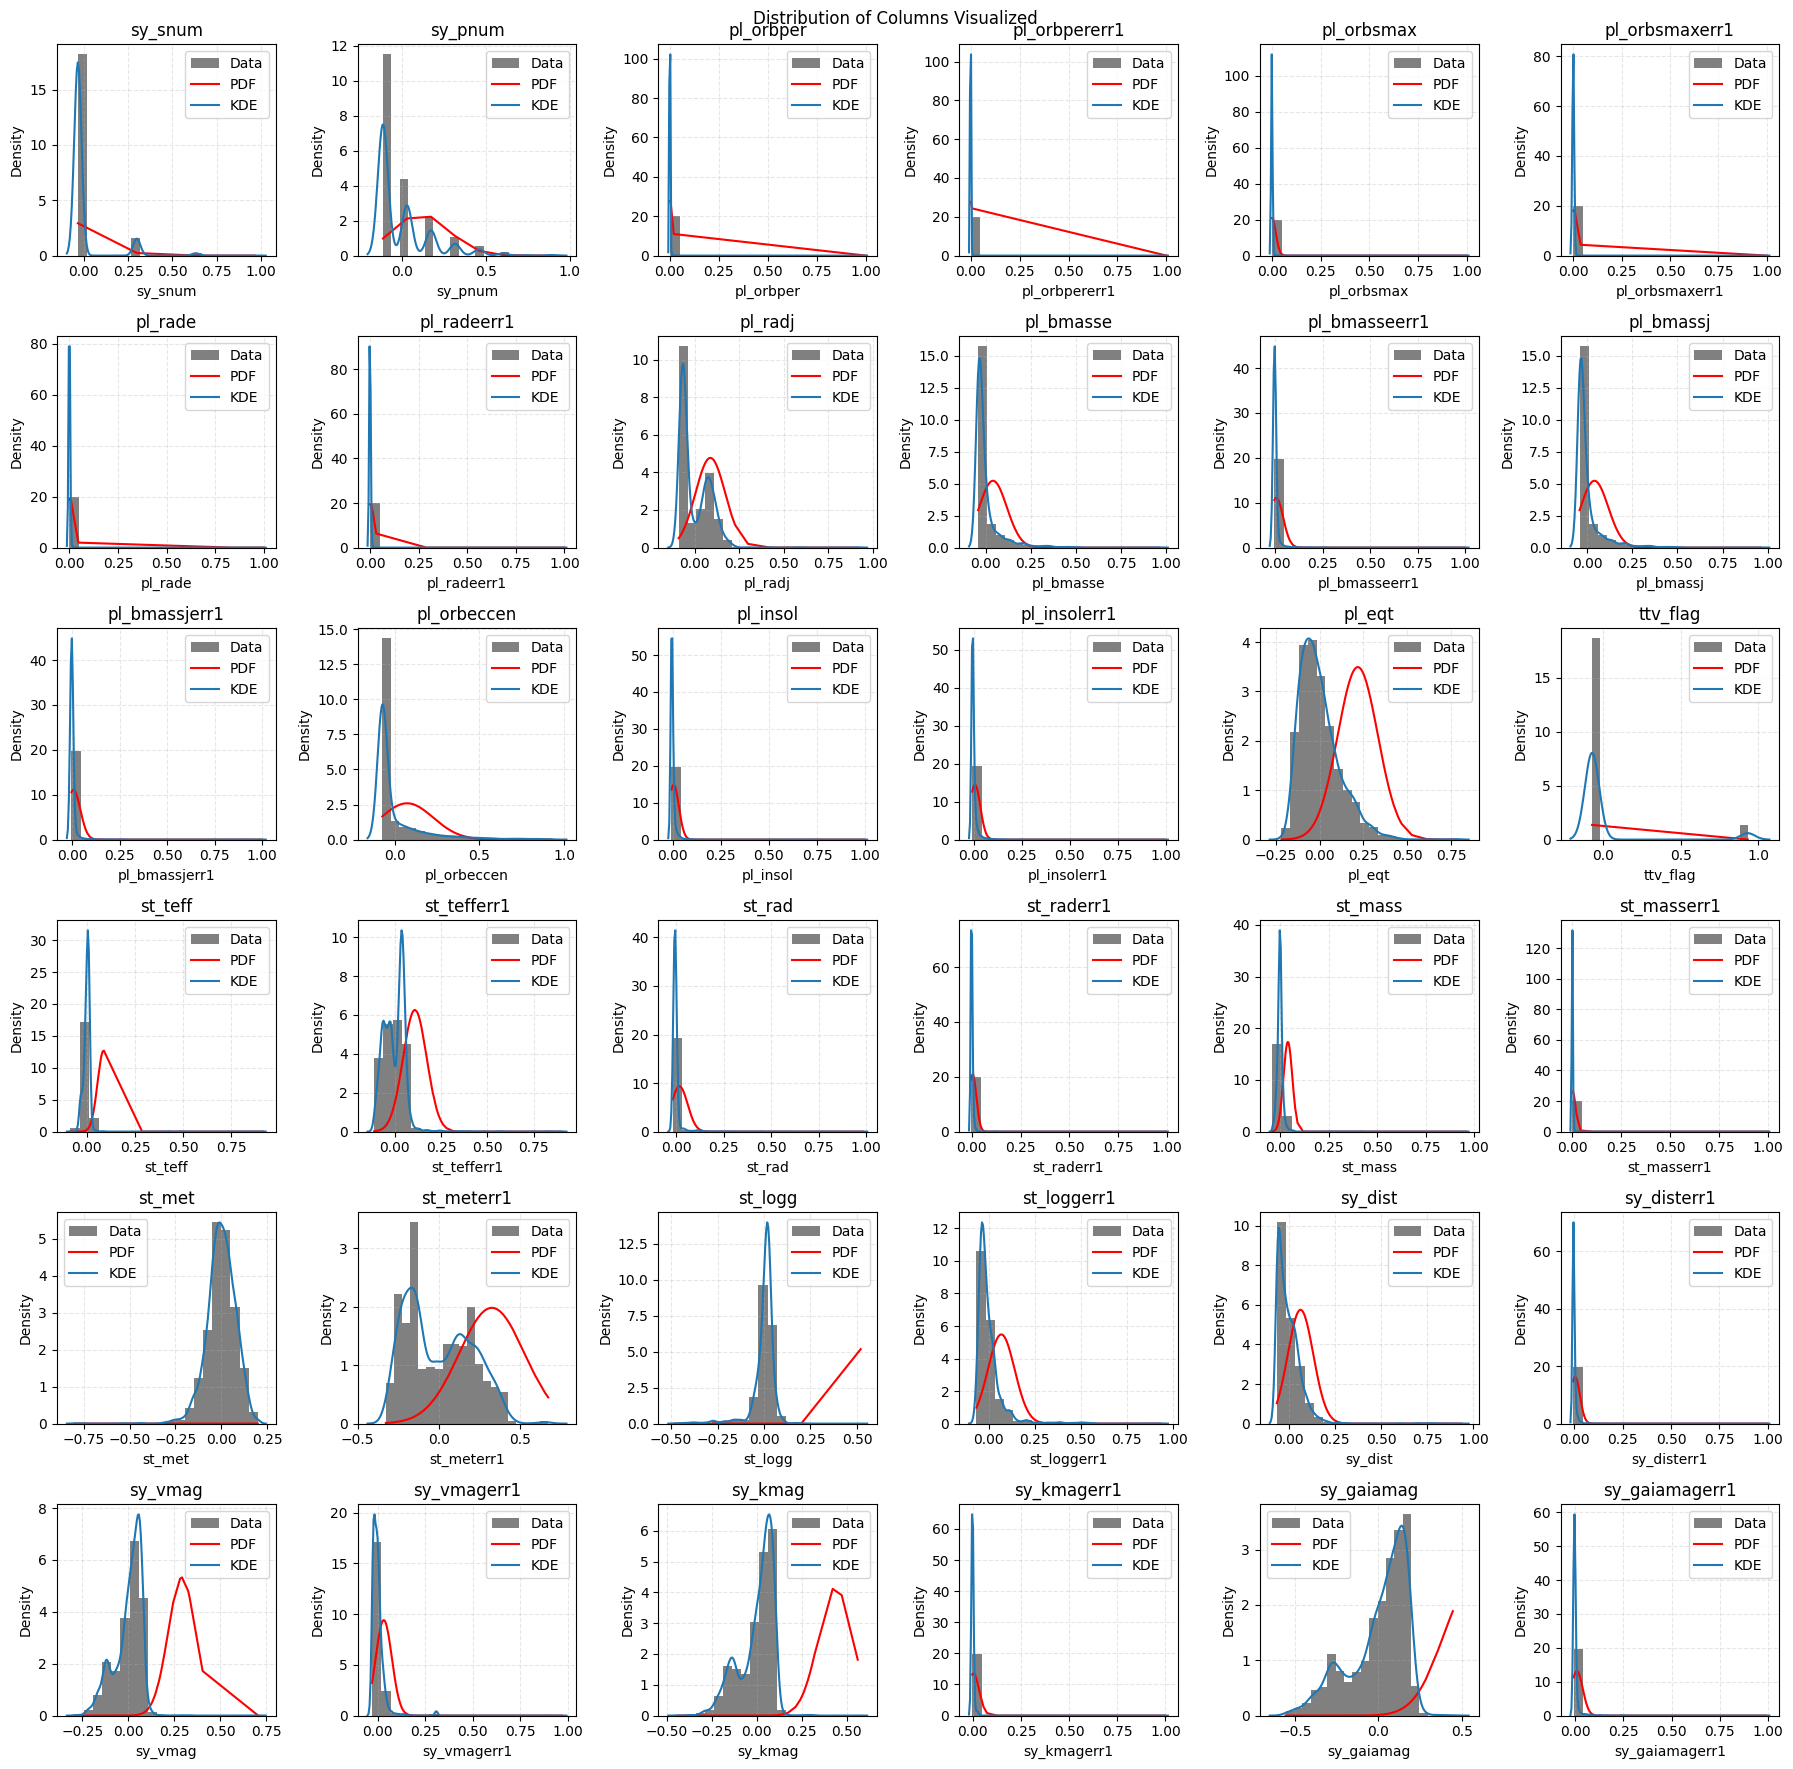

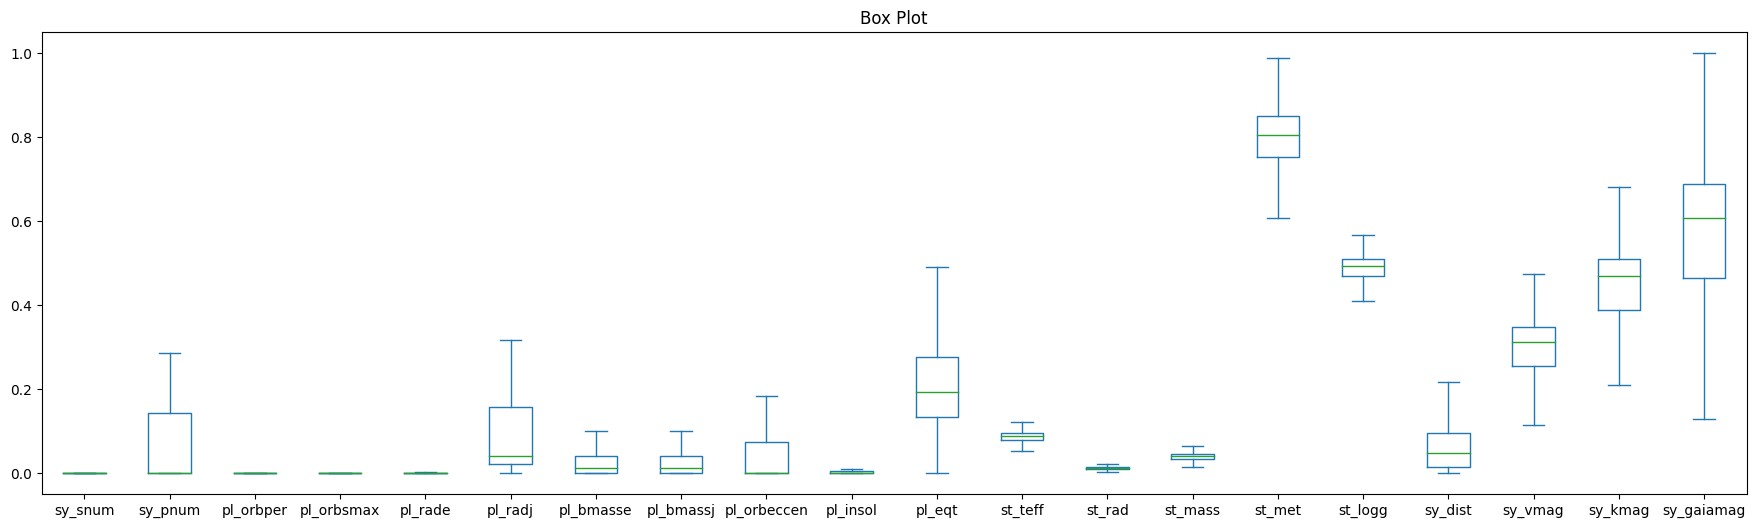

In [109]:
get_cols_info()

#### Using KNNImputation to fill the missing values, the optimal K value was found by K = sqrt(N) N being the number of rows in the data

In [110]:
imputer = KNNImputer(n_neighbors=70)
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns, index = df.index)

#### Analyzing plots of each column after imputation

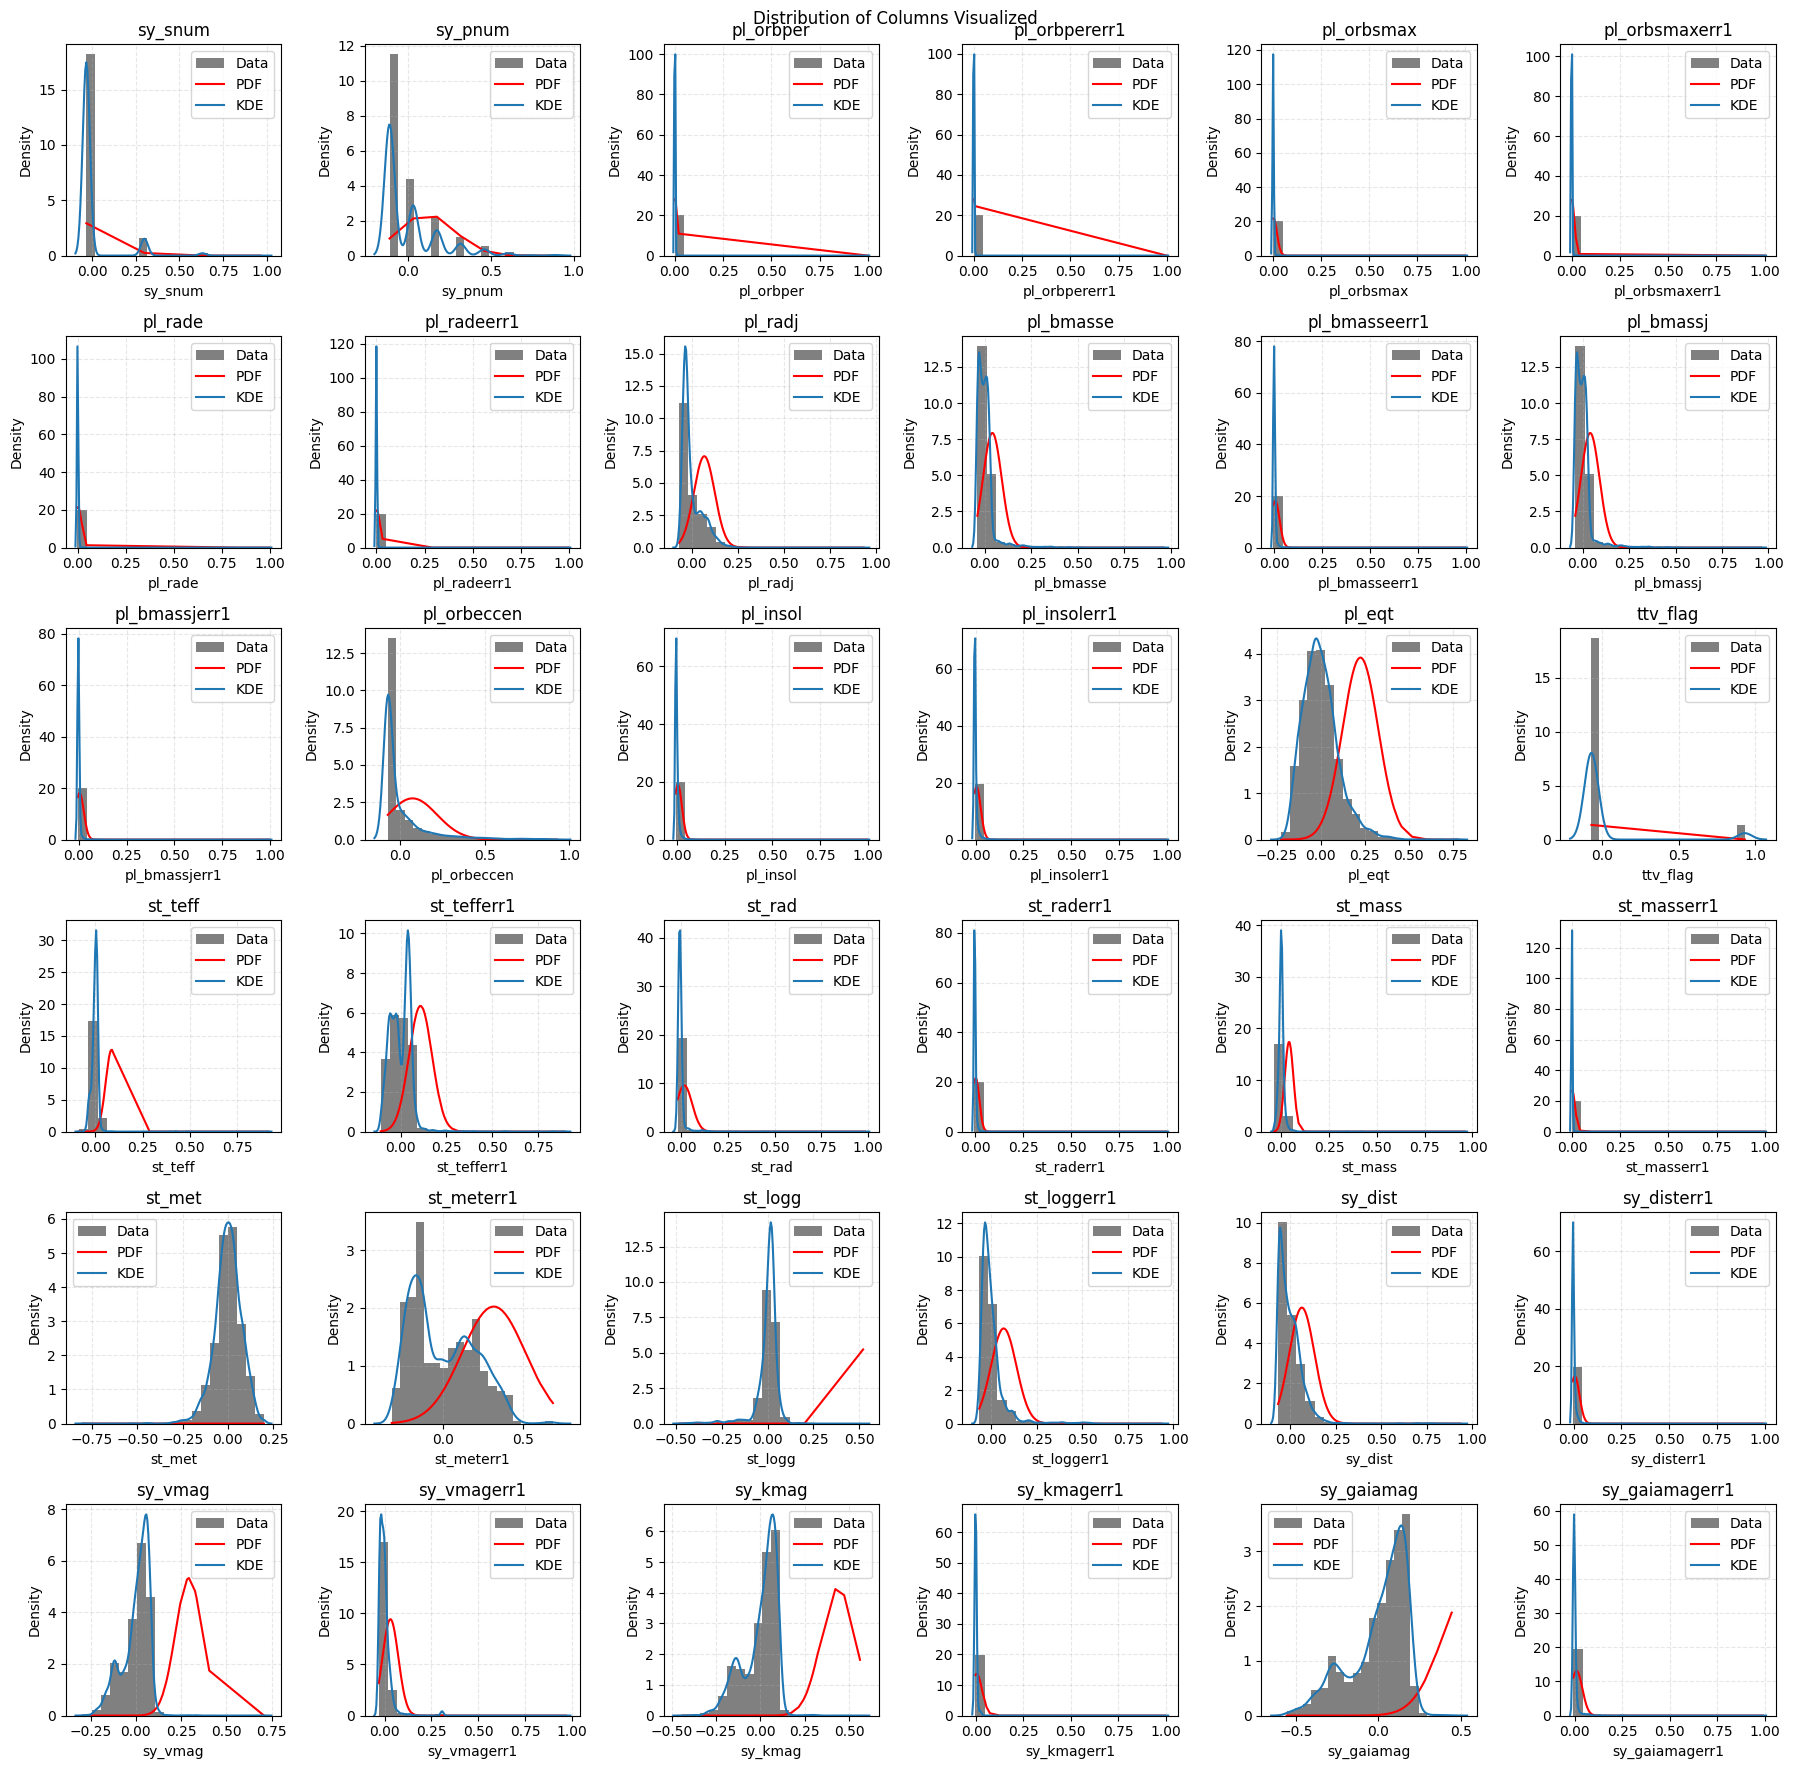

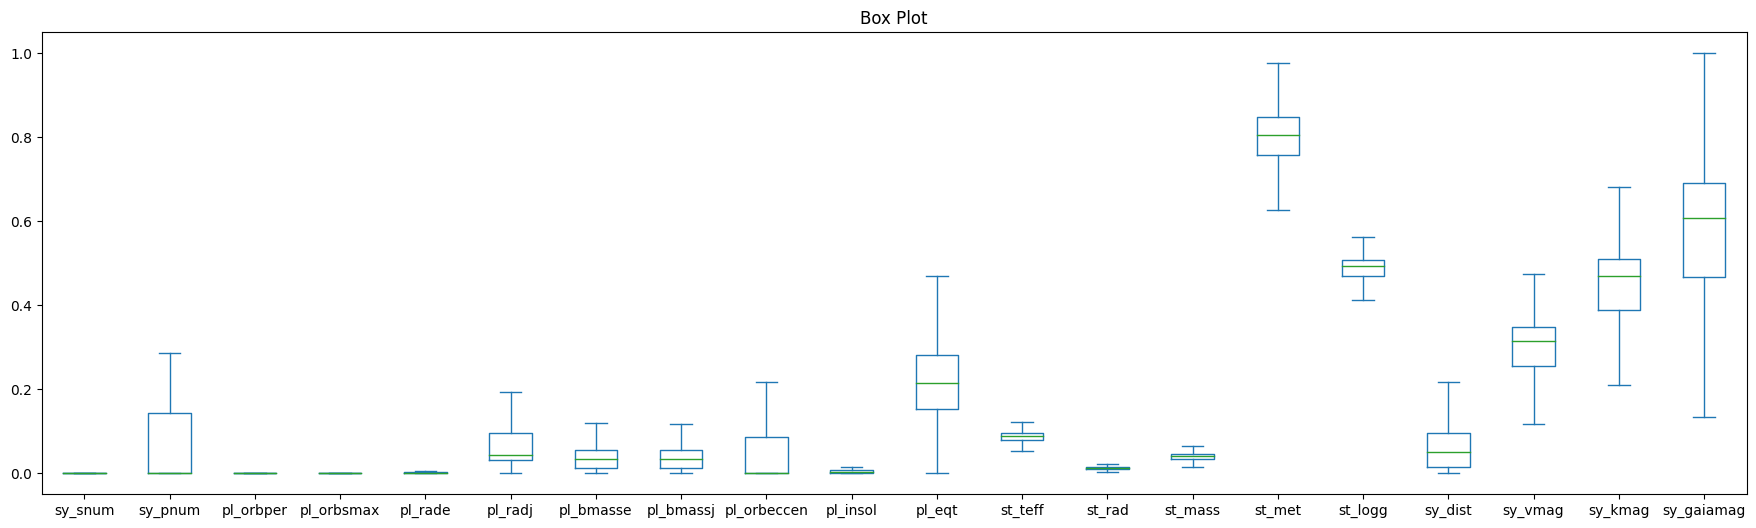

In [111]:
get_cols_info()

#### Checking the total number of null values within the dataframe

In [112]:
df.isna().sum().sum()

0

In [113]:
df.shape

(4935, 36)

#### Validating columns with error margins, some columns have way lower sensivity, thus it was decided to reduce accuracy to minimalize row termination

In [114]:
field_cols = [
    'pl_orbsmax',
    'pl_bmasse',
    'pl_bmassj',
    'sy_dist',
    'st_teff',
    'st_rad',
    'st_mass',
    'st_met',
    'st_logg',
    'sy_vmag',
    'sy_kmag',
    'sy_gaiamag',
    'pl_rade',
    'pl_orbper',
]


#### Check individual rows and drop whose total error margin is above 50%

 A special case is where metallicity is 0, it must not be zero thus half of the error margin is added to the value in order to fix the problem

In [115]:
overall_error_margins = {i:0 for i in df.index}
for i in df.index:
    for col in field_cols:
        if df[col][i] == 0:
            df[col][i] = df[col + 'err1'][i] / 2
            overall_error_margins[i] = (overall_error_margins[i] + df[col][i]) / 2
        else:
            margin = df[col + 'err1'][i] / df[col][i]
            overall_error_margins[i] = (overall_error_margins[i] + margin) / 2

for k,v in overall_error_margins.items():
    if v > 0.5:
        df.drop(i, axis = 'rows')

### Habitable Zone Detection

#### Reversing the scaling for habitable zone calculations

In [116]:
df = pd.DataFrame(scaler.inverse_transform(df), columns = df.columns, index=df.index)
df_habitable_zone = df.copy()

#### Luminosity calculations

In [117]:
df_habitable_zone = df_habitable_zone[["pl_orbsmax","st_rad","st_teff"]]
df_habitable_zone["st_rad_meters"] = df_habitable_zone["st_rad"]*6.957*10**8
df_habitable_zone["st_rad_squared"]=df_habitable_zone["st_rad_meters"]**2
df_habitable_zone["st_teff_power4"]=df_habitable_zone["st_teff"]**4
df_habitable_zone['st_luminosity'] = df_habitable_zone.apply(lambda row: 4*math.pi*row.st_rad_squared*5.67*10**(-8)*row.st_teff_power4, axis = 1)


Calculated luminosity divided to sun's luminosity

In [118]:
df_habitable_zone["st_luminosity_reduced"] = df_habitable_zone["st_luminosity"]/(3.828*10**26)

Max and min distance for habitable zone calculated

In [119]:
df_habitable_zone["st_luminosity_reduced_sqrt"] = df_habitable_zone["st_luminosity_reduced"]**(1/2)
df_habitable_zone["min_distance"] = df_habitable_zone["st_luminosity_reduced_sqrt"]*0.95
df_habitable_zone["max_distance"] = df_habitable_zone["st_luminosity_reduced_sqrt"]*1.37

Finding plantes within the habitable zone

In [120]:
bigger_than_min = df_habitable_zone[df_habitable_zone['pl_orbsmax']>df_habitable_zone['min_distance']]
in_the_zone = bigger_than_min[bigger_than_min['pl_orbsmax']<bigger_than_min['max_distance']]
in_the_zone

,pl_orbsmax,st_rad,st_teff,st_rad_meters,st_rad_squared,st_teff_power4,st_luminosity,st_luminosity_reduced,st_luminosity_reduced_sqrt,min_distance,max_distance
31,0.77330,0.960000,5250.000000,6.678720e+08,4.460530e+17,7.596914e+14,2.414441e+26,0.630732,0.794186,0.754477,1.088035
36,1.90000,2.300000,4792.000000,1.600110e+09,2.560352e+18,5.273115e+14,9.619663e+26,2.512974,1.585236,1.505974,2.171773
48,0.78000,0.860000,4864.000000,5.983020e+08,3.579653e+17,5.597244e+14,1.427605e+26,0.372938,0.610686,0.580152,0.836640
55,0.83000,1.143000,5004.000000,7.951851e+08,6.323193e+17,6.270024e+14,2.824871e+26,0.737950,0.859040,0.816088,1.176885
66,0.68000,1.022714,4746.000000,7.115023e+08,5.062356e+17,5.073538e+14,1.830023e+26,0.478062,0.691421,0.656850,0.947246
...,...,...,...,...,...,...,...,...,...,...,...
4655,0.02817,0.120000,2559.000000,8.348400e+07,6.969578e+15,4.288260e+13,2.129514e+23,0.000556,0.023586,0.022407,0.032313
4678,5.90000,2.734000,7410.989286,1.902044e+09,3.617771e+18,3.016510e+15,7.775686e+27,20.312658,4.506957,4.281609,6.174531
4797,1.07000,0.870000,5545.000000,6.052590e+08,3.663385e+17,9.453795e+14,2.467639e+26,0.644629,0.802888,0.762743,1.099956
4804,1.36000,1.150000,5576.000000,8.000550e+08,6.400880e+17,9.666985e+14,4.408833e+26,1.151733,1.073188,1.019529,1.470268


#### Creating and updating the habitable zone flag

In [121]:
df['pl_zone_flag'] = 0
df.iloc[in_the_zone.index,df.columns.get_loc('pl_zone_flag')] = 1
df.iloc[in_the_zone.index]

,sy_snum,sy_pnum,pl_orbper,pl_orbpererr1,pl_orbsmax,pl_orbsmaxerr1,pl_rade,pl_radeerr1,pl_radj,pl_bmasse,...,st_loggerr1,sy_dist,sy_disterr1,sy_vmag,sy_vmagerr1,sy_kmag,sy_kmagerr1,sy_gaiamag,sy_gaiamagerr1,pl_zone_flag
31,2.0,5.0,260.910000,0.360000,0.77330,0.001000,2.831871,0.210214,0.264714,47.00510,...,0.050000,12.585500,0.012400,5.950840,0.023000,4.015000,0.0360,5.729730,0.000852,1
36,1.0,2.0,763.000000,17.000000,1.90000,0.100000,8.269071,0.873386,0.737986,826.30000,...,0.100000,19.810100,0.164800,3.950000,0.030000,1.564000,0.2520,3.678530,0.004135,1
48,1.0,1.0,268.940000,0.990000,0.78000,0.050000,7.600829,0.626957,0.678786,330.54320,...,0.290000,49.352000,0.084600,9.780000,0.030000,7.336000,0.0230,9.351080,0.000253,1
55,1.0,1.0,307.880000,1.470000,0.83000,0.040000,7.412557,0.565229,0.661286,432.24663,...,0.130000,53.622000,0.191900,9.670000,0.030000,7.557000,0.0240,9.412660,0.000255,1
66,1.0,2.0,237.600000,1.500000,0.68000,0.020000,5.331314,0.557814,0.475629,104.00000,...,0.260000,41.334200,0.068500,9.860000,0.030000,7.323000,0.0210,9.503310,0.000418,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,1.0,7.0,6.099615,0.000011,0.02817,0.000830,0.918000,0.039000,0.082000,0.62000,...,0.083143,701.565214,11.812229,17.020000,0.200000,10.296000,0.0230,15.645100,0.001448,1
4678,2.0,2.0,5840.000000,1095.000000,5.90000,1.400000,7.225214,0.769229,0.974786,2002.20000,...,0.081571,1911.177009,290.611748,16.775300,0.093900,14.776000,0.1240,16.693700,0.063232,1
4797,1.0,2.0,421.000000,2.000000,1.07000,0.030000,2.837986,0.221629,0.253900,1010.69940,...,0.020000,163.371000,1.067000,11.632000,0.018000,9.677000,0.0190,11.282300,0.001447,1
4804,1.0,4.0,572.000000,7.000000,1.36000,0.040000,2.401743,0.554943,0.207971,394.10920,...,0.050000,264.780000,4.888000,11.936000,0.046000,10.192000,0.0260,11.788900,0.000253,1


In [122]:
in_habitable = df.iloc[in_the_zone.index]

#### Re-scaling the data

In [123]:
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index=df.index)

#### Dropping the error margin columns

In [124]:
df = df.drop(columns=[col + 'err1' for col in field_cols])

### Column Analysis

#### Getting Every Column

In [125]:
df.columns

Index(['sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj',
       'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_insolerr1',
       'pl_eqt', 'ttv_flag', 'st_teff', 'st_rad', 'st_mass', 'st_met',
       'st_logg', 'sy_dist', 'sy_vmag', 'sy_kmag', 'sy_gaiamag',
       'pl_zone_flag'],
      dtype='object')

#### Separating columns related to planets or stars for further analysis

In [126]:
df_planets = df.loc[:,df.columns.str.startswith('pl')].copy() # for clustering only planet data
df_stellar = df.loc[:,df.columns.str.startswith('st')].copy() # for clustering only stellar data


### Final Look at the Data

In [127]:
df.head(10)

,sy_snum,sy_pnum,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,...,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,pl_zone_flag
0,0.333333,0.000000,8.105728e-07,0.000171,0.002763,0.145104,0.348966,0.348983,0.250814,0.019658,...,0.073760,0.226638,0.114225,0.597345,0.165179,0.010443,0.091525,0.164578,0.085499,0.0
1,0.000000,0.000000,1.283682e-06,0.000204,0.002978,0.147406,0.188874,0.188882,0.086862,0.007888,...,0.066635,0.287266,0.076008,0.769912,0.059524,0.014095,0.098664,0.153560,0.092572,0.0
2,0.000000,0.000000,4.618415e-07,0.000110,0.002407,0.122121,0.086341,0.086345,0.000000,0.008679,...,0.075018,0.131161,0.092994,0.646018,0.212798,0.008426,0.104040,0.166152,0.113227,0.0
3,0.000000,0.142857,4.393608e-06,0.000376,0.002209,0.109308,0.087244,0.087245,0.398914,0.004890,...,0.083915,0.011815,0.040764,0.931416,0.480655,0.001890,0.138216,0.242698,0.198325,0.0
4,0.666667,0.000000,1.988359e-06,0.000223,0.002522,0.124687,0.030219,0.030220,0.748100,0.007675,...,0.091573,0.013367,0.043312,0.778761,0.468750,0.002255,0.128260,0.240674,0.179814,0.0
5,0.000000,0.000000,1.438309e-06,0.000192,0.003021,0.149514,0.077710,0.077711,0.065147,0.007749,...,0.063391,0.309225,0.051380,0.747788,0.074405,0.014053,0.103910,0.158539,0.103730,0.0
6,0.333333,0.000000,2.470448e-06,0.000346,0.003247,0.160836,0.185276,0.185284,0.086862,0.010599,...,0.077961,0.101325,0.097240,0.729204,0.241071,0.008515,0.110913,0.199398,0.133959,0.0
7,0.000000,0.000000,2.377407e-08,0.043964,0.000513,0.028659,0.169796,0.143910,0.062494,0.021936,...,0.060484,0.015515,0.025902,0.744014,0.416667,0.015665,0.285914,0.377674,0.527879,0.0
8,0.000000,0.000000,7.505195e-08,0.000025,0.002386,0.121190,0.016369,0.016369,0.045603,0.007481,...,0.076436,0.126865,0.041614,0.411504,0.181548,0.010761,0.112871,0.192749,0.137394,0.0
9,0.000000,0.142857,1.125921e-06,0.000177,0.001834,0.090893,0.035795,0.035797,0.097720,0.005288,...,0.080070,0.058360,0.064968,0.738938,0.342262,0.008043,0.134132,0.228918,0.187913,0.0


In [128]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4935 entries, 0 to 4934
Columns: 23 entries, sy_snum to pl_zone_flag
dtypes: float64(23)
memory usage: 886.9 KB


## Modeling<a class="anchor" id="modeling"></a>

### Optimizing Clustering Method

#### Calculating and plotting inertias

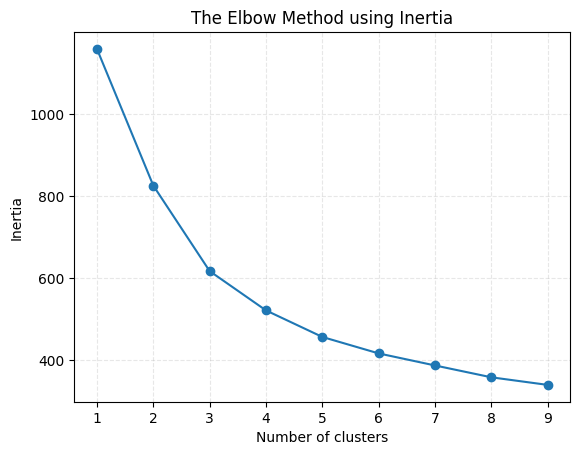

In [129]:
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

### Performing Principal Component Analysis (PCA) 

Performing principal component analysis in order to show the outcome of the clustering in 2D graphs

#### Performing PCA on default attributes

In [141]:
pca_data = PCA()
reduced_data = pca_data.fit_transform(df)
results_df = pd.DataFrame(reduced_data,index = df.index)
results_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.422116,0.531593,-0.162979,-0.099778,-0.121900,-0.021180,0.327228,0.235086,0.393232,-0.084577,...,-0.017341,-0.014685,-0.012087,-0.000979,0.000146,0.003393,0.013496,0.006528,-0.007134,-0.000034
1,-0.371173,0.453540,-0.145734,-0.143651,-0.092297,-0.299530,0.013385,0.144397,0.346562,0.047283,...,-0.022790,-0.000260,0.006687,-0.047561,0.001706,-0.013889,0.007941,0.001685,-0.002535,-0.000044
2,-0.310759,0.364550,-0.085591,-0.135943,-0.130856,-0.344337,0.096148,0.064106,0.126096,0.054751,...,-0.018221,-0.024652,0.000798,-0.003076,-0.000100,0.031787,0.017384,0.001017,-0.001123,-0.000046
3,-0.302502,0.442002,0.010854,-0.054906,0.172038,0.037768,-0.120408,-0.075908,0.045219,-0.030499,...,0.011542,0.004008,-0.006944,-0.004433,0.000579,-0.002466,-0.006293,-0.000793,-0.001654,0.000097
4,-0.451873,0.646630,-0.143603,0.001618,0.028100,0.588116,0.291384,-0.068323,-0.069771,0.070004,...,0.002680,-0.001465,0.000578,0.009668,0.001194,-0.003463,-0.008580,-0.003905,0.000719,0.000003


In [142]:
exp_var_pca_data = pca_data.explained_variance_ratio_
exp_var_pca_data

array([3.07498663e-01, 2.31036267e-01, 1.11882177e-01, 9.41123927e-02,
       5.58894548e-02, 5.17094230e-02, 4.54255123e-02, 3.48651829e-02,
       2.09034703e-02, 1.46309689e-02, 9.56403829e-03, 6.21165803e-03,
       4.20420812e-03, 2.46166335e-03, 2.28348638e-03, 2.01940600e-03,
       1.57141907e-03, 1.45804353e-03, 9.15682815e-04, 7.46632577e-04,
       3.80905206e-04, 2.28884225e-04, 4.60387100e-07])

In [140]:
pca_data.n_components_

8

#### Performing PCA on plantery attributes

In [51]:
pca_planet = PCA(n_components=2)
reduced_data_planets = pca_planet.fit_transform(df_planets)
results_planets = pd.DataFrame(reduced_data_planets,columns=['pca1','pca2'],index = df_planets.index)
results_planets.tail()

,pca1,pca2
4930,-0.056915,0.010264
4931,0.646266,0.755427
4932,-0.079992,0.086471
4933,-0.016502,0.026382
4934,-0.048975,0.062429


In [52]:
exp_var_pca_planet = pca_planet.explained_variance_ratio_
exp_var_pca_planet

array([0.39657459, 0.30195581])

#### Performing PCA on stellar attributes

In [53]:
pca_stellar = PCA(n_components=2)
reduced_data_stellar = pca_stellar.fit_transform(df_stellar)
results_stellar = pd.DataFrame(reduced_data_stellar,columns=['pca1','pca2'],index = df_stellar.index)
results_stellar.head()

,pca1,pca2
0,0.108432,0.385680
1,-0.069581,0.487775
2,0.063627,0.290264
3,-0.199848,-0.023424
4,-0.048767,-0.002160


In [54]:
exp_var_pca_stellar = pca_stellar.explained_variance_ratio_
exp_var_pca_stellar

array([0.59354713, 0.2948471 ])

#### Separating PCA values of planets within repsective host stars habitable zone

In [55]:
results_habitable = results_df.iloc[in_habitable.index]
results_habitable

,pca1,pca2
31,-0.200448,0.583628
36,-0.373309,0.612522
48,-0.277701,0.329691
55,-0.238076,0.249944
66,-0.208111,0.297623
...,...,...
4655,1.017003,0.496664
4678,0.007253,-0.123928
4797,-0.156771,0.219856
4804,-0.042774,0.196640


### KMeans Clustering

#### Perform KMeans clustering on default results

In [56]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) 
kmeans.fit(results_df)
y = kmeans.predict(results_df)
centers = kmeans.cluster_centers_

Put clusters inside dataframe as a column

In [57]:
results_df['clusters'] = y 
results_df.head() 

,pca1,pca2,clusters
0,-0.422116,0.531593,2
1,-0.371173,0.453540,2
2,-0.310759,0.364550,2
3,-0.302502,0.442002,2
4,-0.451873,0.646630,2


**Kmeans on data without PCA and comparing with PCA data clustering**

In [58]:
kmeans_normal_data = KMeans(n_clusters=3, n_init=100, max_iter=500) 
kmeans_normal_data.fit(df)
y = kmeans_normal_data.predict(df)
centers = kmeans_normal_data.cluster_centers_

In [59]:
df["Clusters"] = y
df.Clusters.value_counts()

0    3325
1    1270
2     340
Name: Clusters, dtype: int64

In [60]:
different_cluster_num = 0
for i in df.index:
    if int(df.iloc[i].Clusters) != int(results_df.iloc[i].clusters):
        different_cluster_num += 1

different_cluster_num

1621

Checking for number of planets in each cluster

In [61]:
results_df.clusters.value_counts()

0    3315
2    1280
1     340
Name: clusters, dtype: int64

#### Perform KMeans clustering on planetary results

In [62]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) #n_init="auto" ne yapıyor tam olarak bak!!!
kmeans.fit(results_planets)
y = kmeans.predict(results_planets)
pl_centers = kmeans.cluster_centers_

Put clusters inside dataframe as a column

In [63]:
results_planets['clusters'] = y
results_planets.head()

,pca1,pca2,clusters
0,0.152677,-0.207150,2
1,0.023114,-0.079043,0
2,-0.052273,0.004246,0
3,0.215849,-0.244605,2
4,0.452828,-0.484055,2


Checking for number of planets in each cluster

In [64]:
results_planets.clusters.value_counts()

0    4295
2     529
1     111
Name: clusters, dtype: int64

#### Perform KMeans clustering on stellar results

In [65]:
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500) #n_init="auto" ne yapıyor tam olarak bak!!!
kmeans.fit(results_stellar)
y = kmeans.predict(results_stellar)
st_centers = kmeans.cluster_centers_

Put clusters inside dataframe as a column

In [66]:
results_stellar['clusters'] = y
results_stellar.head()

,pca1,pca2,clusters
0,0.108432,0.385680,2
1,-0.069581,0.487775,2
2,0.063627,0.290264,2
3,-0.199848,-0.023424,0
4,-0.048767,-0.002160,0


Checking for number of planets in each cluster

In [67]:
results_stellar.clusters.value_counts()

0    2539
1    2257
2     139
Name: clusters, dtype: int64

### Hierarchical Clustering

#### Performing Hierarchical Clustering

This clustering will be used to compare the accuracy of KMeans clustering

In [68]:

data = list(zip(results_df["pca1"], results_df["pca2"]))
linkage_data = linkage(data, method='ward', metric='euclidean')
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(data)


## Evaluation<a class="anchor" id="evaluation"></a>

### Defining plotting function

In [69]:
colors = ['#DF2020', '#81DF20', '#2095DF']
def plot_clusters(df: pd.DataFrame, title: str, centers) -> pd.DataFrame:
    results_df['c'] = df['clusters'].map({0: colors[0], 1: colors[1], 2: colors[2]})

    fig = plt.gcf()
    fig.set_size_inches(16,9)
    sns.scatterplot(x="pca1", y="pca2", hue=df['clusters'], data=df, alpha=0.5, palette=colors)
    plt.title(title)


    pca1 = df['pca1']
    pca2 = df['pca2']
    # plot pca1 mean
    plt.plot([pca1.mean()] * 2, [-pca1.max(),pca1.max()], color='black', lw=0.5, linestyle='--')
    # plot pca2 mean
    plt.plot([-pca2.max(),pca2.max()], [pca2.mean()]*2, color='black', lw=0.5, linestyle='--')
    
    for i in df.clusters.unique():
        # get the convex hull
        points = df[df.clusters == i][['pca1','pca2']].values
        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                        points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                        points[hull.vertices,1][0])
        
        # interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], 
                                        u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        # plot shape
        plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)

    # create a list of legend elemntes
    ## average line
    legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
    ## markers / records
    cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
    ## centroids
    cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
                markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
    # add all elements to the same list
    legend_elements.extend(cluster_leg)
    legend_elements.extend(cent_leg)
    # plot legend

    e_index = label_df[label_df['pl_name'] == 'Earth'].index
    m_index = label_df[label_df['pl_name'] == 'Mars'].index
    v_index = label_df[label_df['pl_name'] == 'Venus'].index
    j_index = label_df[label_df['pl_name'] == 'Jupiter'].index
    # First one below is in the habitable zone and second one below is not in habitable zone
    t_index = label_df[label_df['pl_name'] == 'TRAPPIST-1 g'].index
    b_index = label_df[label_df['pl_name'] == 'tau Boo b'].index

    e_cluster = df.iloc[e_index].clusters.values[0]

    plt.scatter(centers[:, 0], centers[:, 1], c=colors, marker = '^', s=100,edgecolors= "black")

    plt.scatter(df.iloc[e_index]['pca1'],df.iloc[e_index]['pca2'], c='darkblue',edgecolors= "black")
    plt.scatter(df.iloc[m_index]['pca1'],df.iloc[m_index]['pca2'], c='orange',edgecolors= "black")
    plt.scatter(df.iloc[v_index]['pca1'],df.iloc[v_index]['pca2'], c='lightblue',edgecolors= "black")
    plt.scatter(df.iloc[j_index]['pca1'],df.iloc[j_index]['pca2'], c='yellow',edgecolors= "black")
    plt.scatter(df.iloc[t_index]['pca1'],df.iloc[t_index]['pca2'], c='green',edgecolors= "black")
    plt.scatter(df.iloc[b_index]['pca1'],df.iloc[b_index]['pca2'], c='purple',edgecolors= "black")

    legend_elements.extend([Line2D([0], [0], marker='o', color='w', label=name, mec = 'black',
                markerfacecolor=color, markersize=10) for name, color in {'Earth':'darkblue','Mars':'orange','Venus':'lightblue','Jupiter':'yellow','TRAPPIST-1 g':'green','tau Boo b':'purple'}.items()])


    plt.legend(handles=legend_elements, loc='upper right', ncol=2)
    plt.show()
    return_df = label_df.iloc[df[df['clusters'] == e_cluster].index]
    return_df = return_df.drop(index=e_index)
    return return_df

### Evaluating based on default results

#### KMeans Cluster Plot

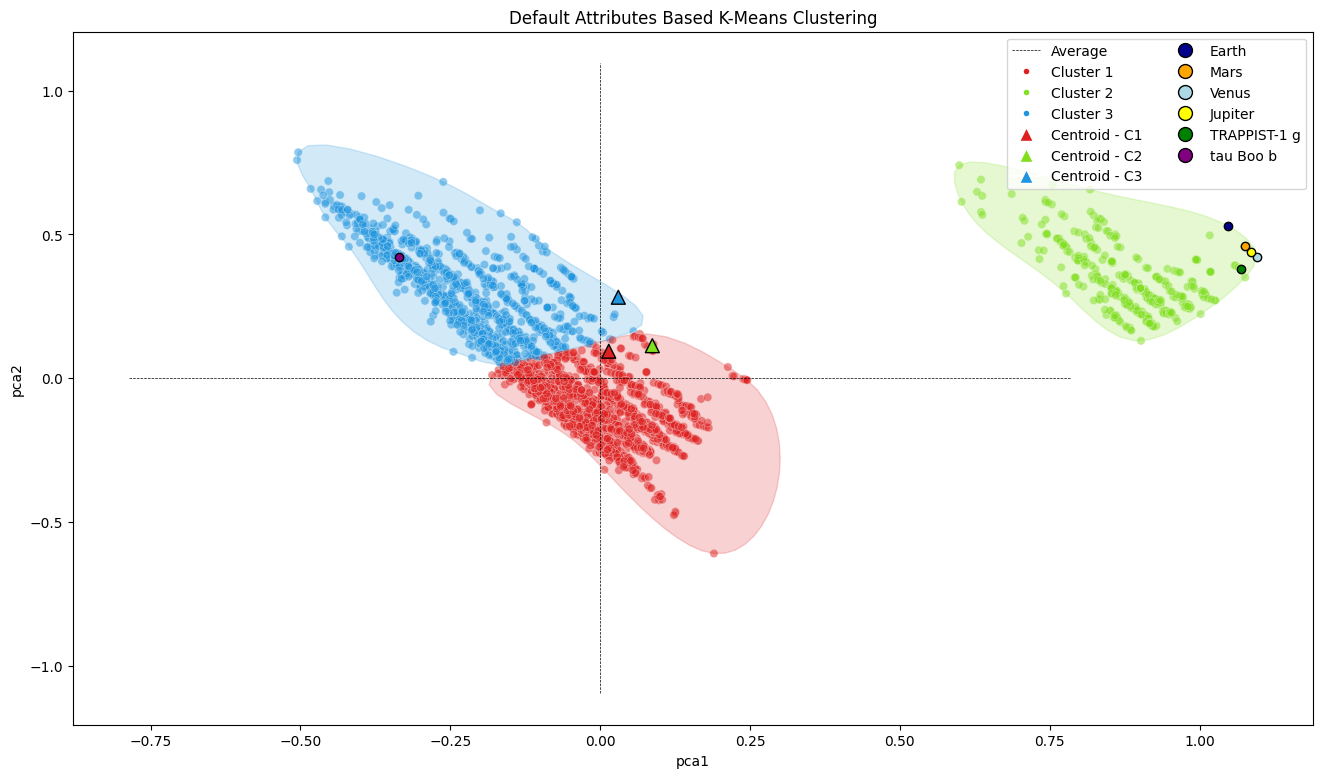

In [70]:
overall_clustered = plot_clusters(results_df,'Default Attributes Based K-Means Clustering',centers)

#### Planets within the same cluster of Earth

In [71]:
overall_clustered

,pl_name,hostname
45,AU Mic b,AU Mic
89,CoRoT-2 b,CoRoT-2
296,HAT-P-13 b,HAT-P-13
855,HD 28109 c,HD 28109
856,HD 28109 d,HD 28109
...,...,...
4803,WASP-47 b,WASP-47
4805,WASP-47 d,WASP-47
4932,Venus,Sol
4933,Mars,Sol


#### Hierarchical Clustering of default attributes for comparison

##### Dendrogram Plot

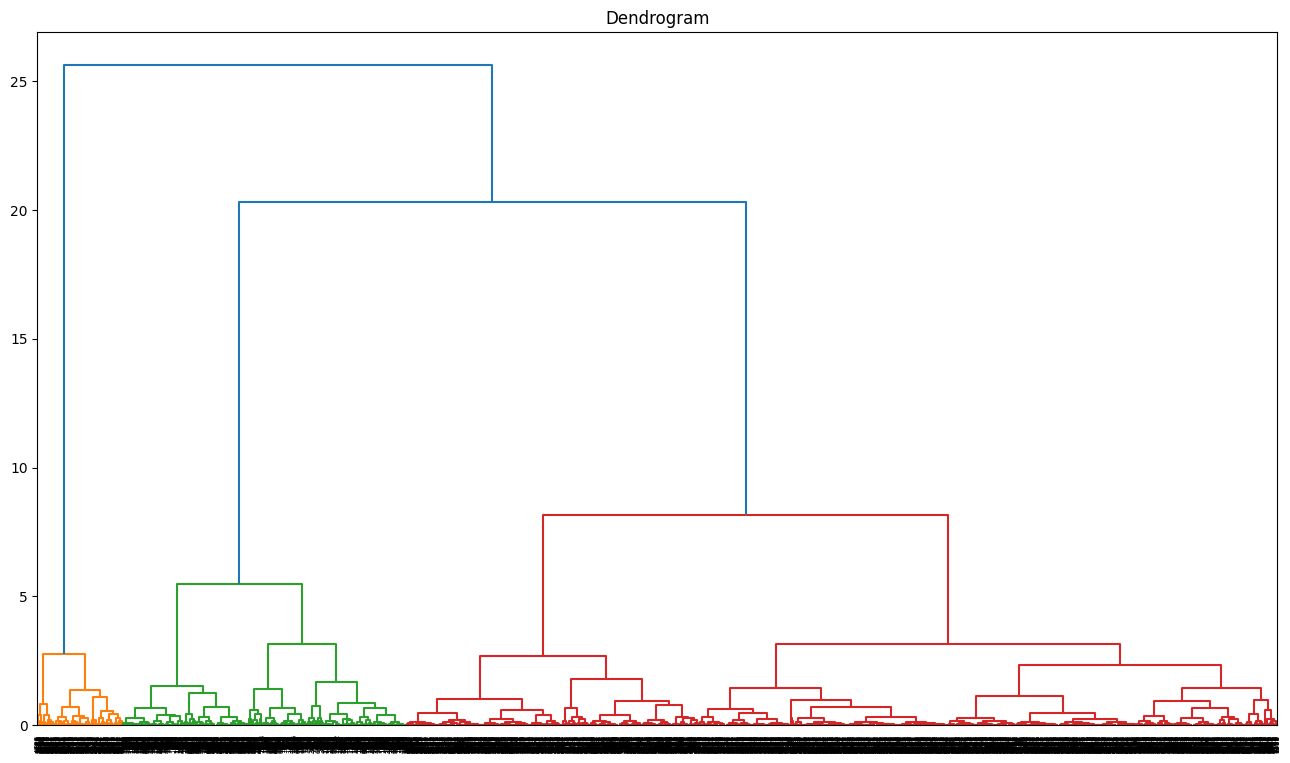

<Figure size 2000x2000 with 0 Axes>

In [72]:
fig = plt.gcf()
fig.set_size_inches(16,9)
dendrogram(linkage_data)
plt.title("Dendrogram")
plt.figure(figsize=(20,20))
plt.show()

##### Scatter Plot

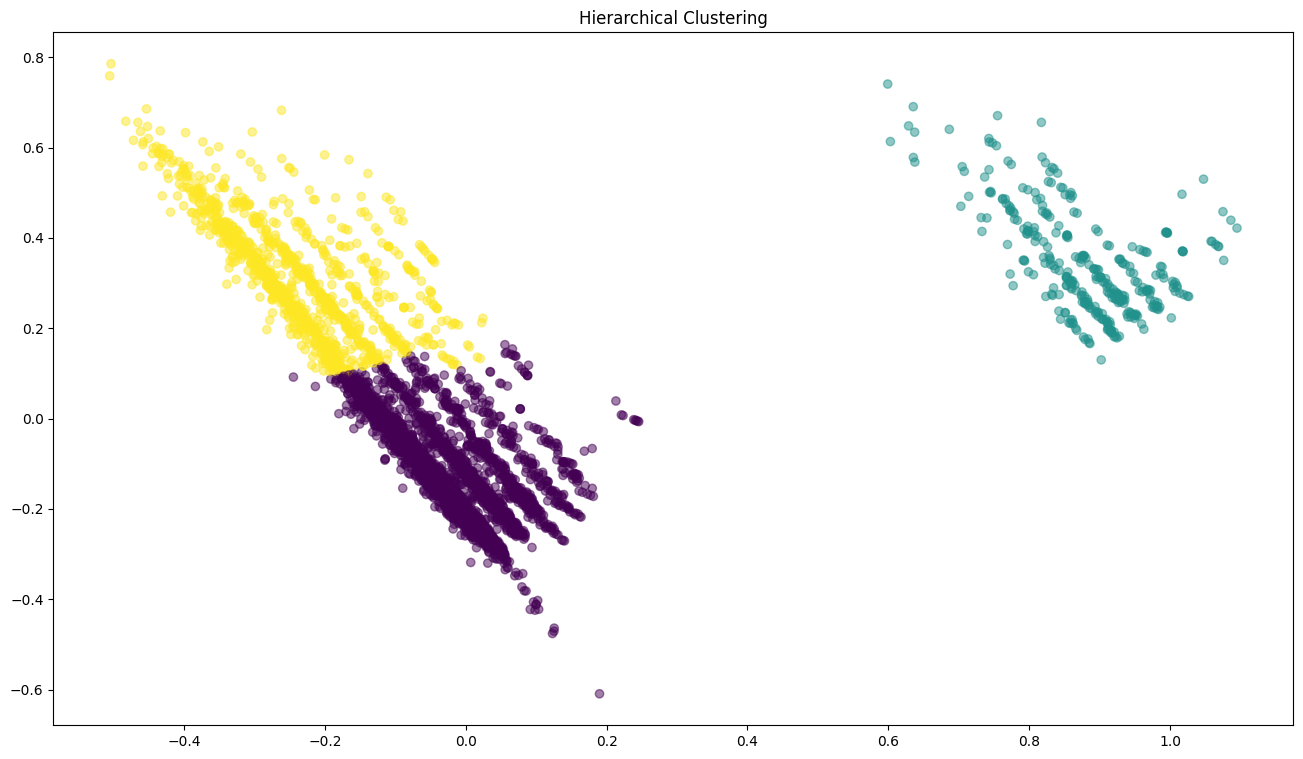

In [73]:
data_x=[i[0] for i in data]
data_y=[i[1] for i in data]

fig = plt.gcf()
fig.set_size_inches(16,9)

plt.scatter(data_x, data_y, c=labels, alpha=0.5)
plt.title("Hierarchical Clustering")
plt.show()

### Evaluating based on planetary results

#### Scatter Plot

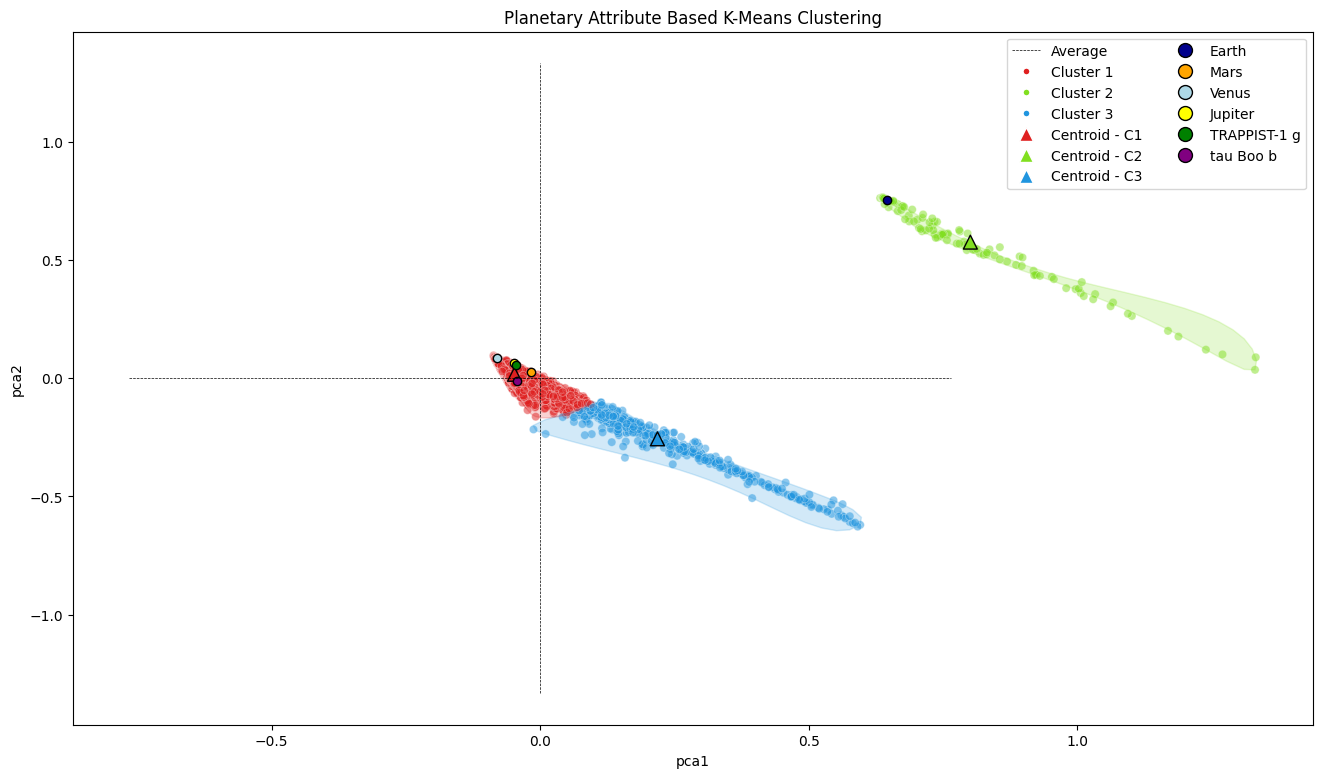

In [74]:
pl_clustered = plot_clusters(results_planets, 'Planetary Attribute Based K-Means Clustering', pl_centers)

#### Planets within the same cluster of Earth

In [75]:
pl_clustered

,pl_name,hostname
31,55 Cnc f,55 Cnc
36,7 CMa b,7 CMa
48,BD+14 4559 b,BD+14 4559
55,BD+45 564 b,BD+45 564
66,BD-08 2823 c,BD-08 2823
...,...,...
4637,TOI-700 d,TOI-700
4655,TRAPPIST-1 e,TRAPPIST-1
4678,UZ For b,UZ For
4797,WASP-41 c,WASP-41


### Evaluating based on Stellar Results

#### Scatter Plot

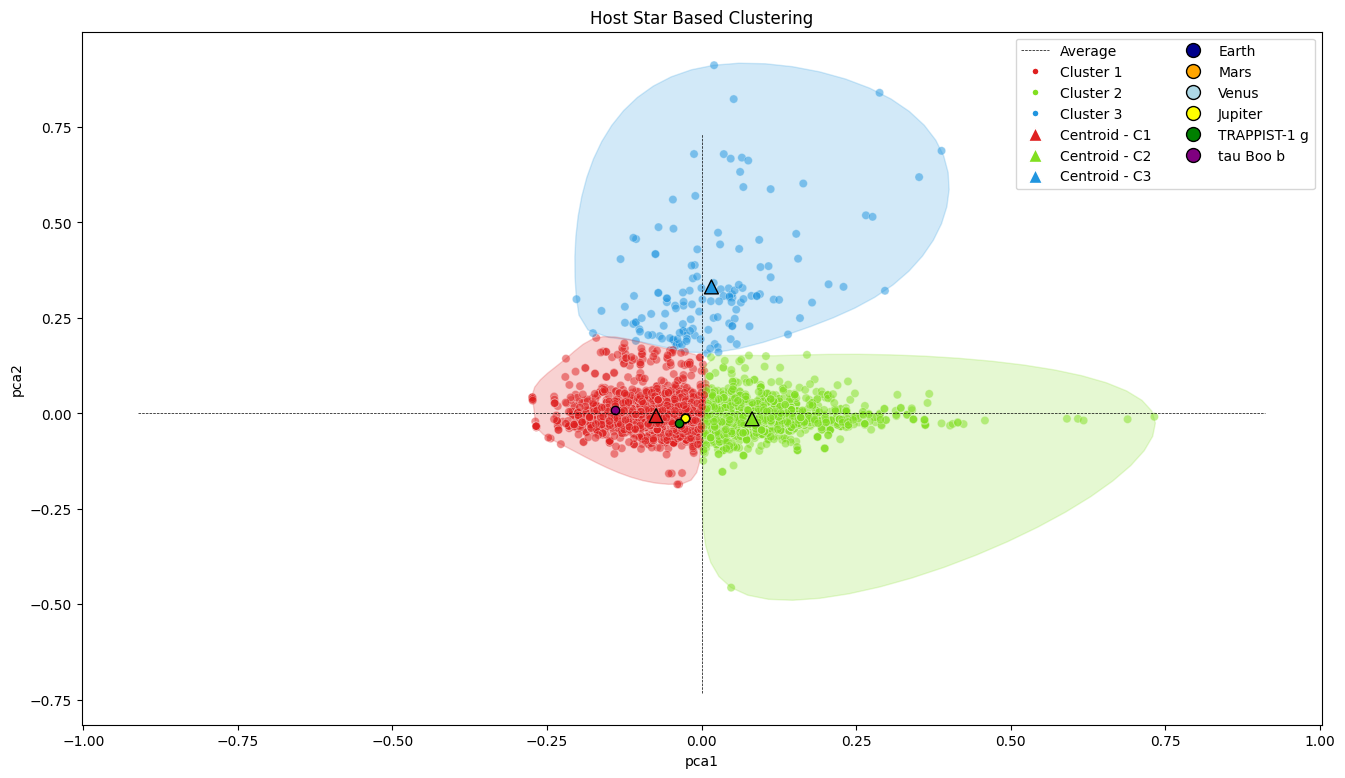

In [76]:
st_clustered = plot_clusters(results_stellar, 'Host Star Based Clustering', st_centers)

#### Planets within the same cluster of Earth

In [77]:
st_clustered

,pl_name,hostname
3,14 Her b,14 Her
4,16 Cyg B b,16 Cyg B
7,1RXS J160929.1-210524 b,1RXS J160929.1-210524
9,24 Sex b,24 Sex
10,24 Sex c,24 Sex
...,...,...
4927,ups And c,ups And
4928,ups And d,ups And
4932,Venus,Sol
4933,Mars,Sol


### Evaluating based on Habitabile Zone Flag Results

#### Scatter Plot

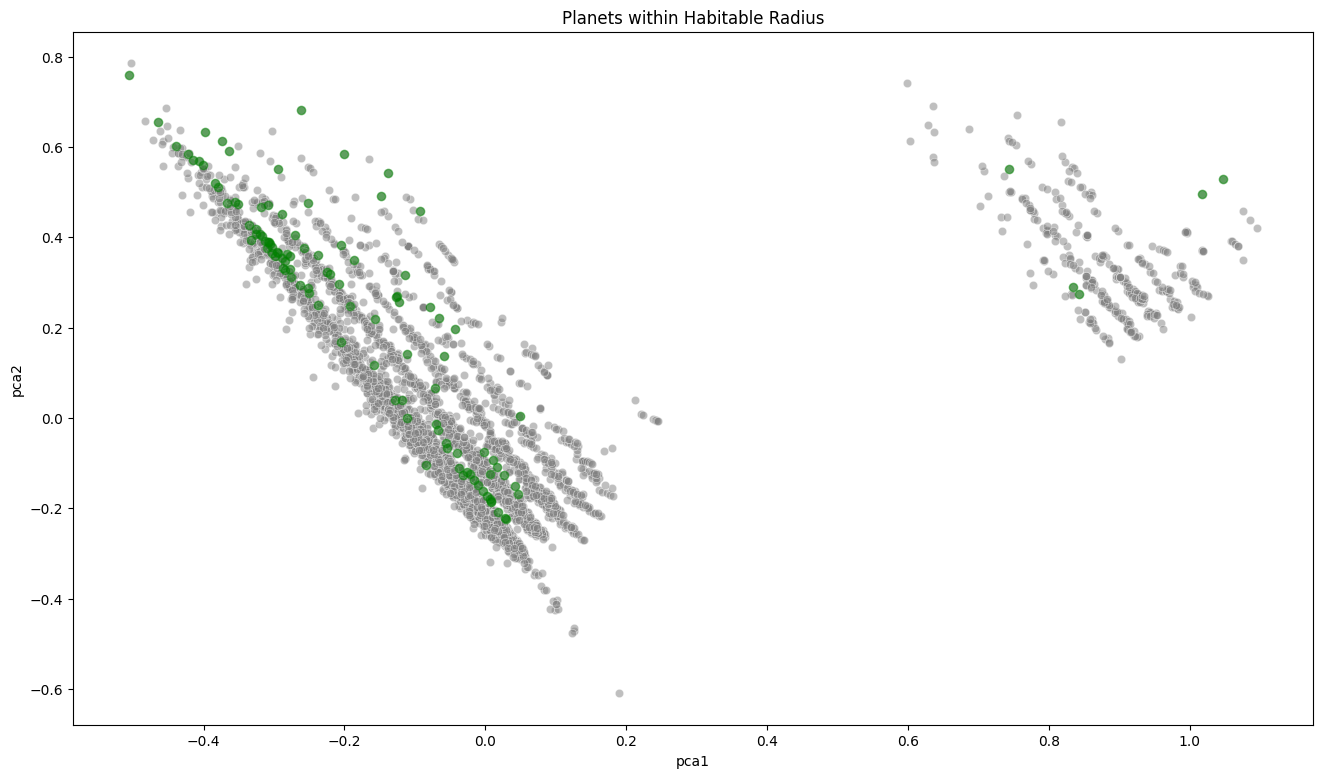

In [78]:
# scatter plot of distribution of planets in habitable zone among all other planets
fig = plt.gcf()
fig.set_size_inches(16,9)
sns.scatterplot(x="pca1", y="pca2", data=results_df, alpha=0.5, color = 'gray')
plt.title('Planets within Habitable Radius')

plt.scatter(results_habitable['pca1'],results_habitable['pca2'], c='green', alpha=0.5)

plt.show()

### Final Evaluation of Multiple Clusterings

#### Planetary Clustering Results

In [79]:
final_df = pl_clustered
final_df

,pl_name,hostname
31,55 Cnc f,55 Cnc
36,7 CMa b,7 CMa
48,BD+14 4559 b,BD+14 4559
55,BD+45 564 b,BD+45 564
66,BD-08 2823 c,BD-08 2823
...,...,...
4637,TOI-700 d,TOI-700
4655,TRAPPIST-1 e,TRAPPIST-1
4678,UZ For b,UZ For
4797,WASP-41 c,WASP-41


#### Planetary Clustering / Stellar Clustering Intersection Results

In [80]:
final_df = pd.concat([final_df, st_clustered], axis=1, join='inner')
final_df

,pl_name,hostname,pl_name,hostname
31,55 Cnc f,55 Cnc,55 Cnc f,55 Cnc
36,7 CMa b,7 CMa,7 CMa b,7 CMa
48,BD+14 4559 b,BD+14 4559,BD+14 4559 b,BD+14 4559
174,GJ 1148 b,GJ 1148,GJ 1148 b,GJ 1148
193,GJ 229 b,GJ 229,GJ 229 b,GJ 229
...,...,...,...,...
4541,TOI-1516 b,TOI-1516,TOI-1516 b,TOI-1516
4655,TRAPPIST-1 e,TRAPPIST-1,TRAPPIST-1 e,TRAPPIST-1
4678,UZ For b,UZ For,UZ For b,UZ For
4797,WASP-41 c,WASP-41,WASP-41 c,WASP-41


#### Planetary Clustering / Stellar Clustering / Overall Clustering Intersection Results

In [81]:
final_df = pd.concat([final_df, overall_clustered], axis=1, join='inner')
final_df

,pl_name,hostname,pl_name,hostname,pl_name,hostname
4655,TRAPPIST-1 e,TRAPPIST-1,TRAPPIST-1 e,TRAPPIST-1,TRAPPIST-1 e,TRAPPIST-1


It appears that TRAPPIST-1e is the most habitable planet in the given dataset, however the remaining 63 planets displayed above are also strong candidates.

## References<a class="anchor" id="references"></a>

List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remeber, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries will be punished badly.\
<a href="https://urc.ucdavis.edu/how-write-abstract"> Undergraduate Research Center, How to Write an Abstract?</a> <br>
<a href="https://app.datacamp.com/learn/courses/unsupervised-learning-in-python"> Datacamp, Unsupervised Machine Learning in Python </a> <br>
<a href="https://machinelearningmastery.com/probability-density-estimation/"> Probability Denstiy Function or Kernel Density Function? </a> <br>
<a href="https://towardsdatascience.com/probability-distribution-functions-demystified-a6e882759af3"> Understanding Probability Mass Function </a> <br>
<a href="https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/">KNN Imputation in Machine Learning </a> <br>
<a href="https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb"> Optimal K value in KNN Imputation </a> <br>
<a href="https://educationalresearchtechniques.com/2018/10/17/kmeans-clustering-in-python/"> How to utilize the Elbow Method for Finding Optimal Cluster Size </a> <br>
<a href="https://chartio.com/learn/charts/box-plot-complete-guide/"> A Complete Guide to Box Charts <a> <br>
<a href="https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489"> Visualizing Clusters with Python’s Matplotlib </a> <br>
<a href="http://astroweb.case.edu/ssm/ASTR620/mags.html"> Astronomical Magnitude Systems <a> <br>
<a href="https://en.wikipedia.org/wiki/Metallicity"> Metallicity, Wikipedia <a> <br>
<a href="https://exoplanets.nasa.gov/search-for-life/habitable-zone/%22%3E"> Habitable Zone, Nasa <a> <br>
<a href="https://www.atnf.csiro.au/outreach/education/senior/astrophysics/photometry_luminosity.html#:~:text=Luminosity%2C%20L%2C%20is%20a%20measure,is%20called%20its%20bolometric%20luminosity%22%3E"> Luminosity Calculation <a> <br>
<a href="https://www.bbvaopenmind.com/en/science/physics/planetary-systems-and-the-habitable-zone/%22%3E"> Distance According to Luminosity<a> <br>
<a href="https://www.geeksforgeeks.org/principal-component-analysis-with-python/%22%3E"> Principal Component Analysis<a> <br>
<a href="https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer%22%3E"> PCA Explained<a> <br>
<a href="https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186#:~:text=Principal%20component%20analysis%2C%20or%20PCA,more%20easily%20visualized%20and%20analyzed.
"> Why PCA Is Used?<a> <br>
<a href="https://www.section.io/engineering-education/clustering-in-unsupervised-ml/#:~:text=The%20main%20types%20of%20clustering,Gaussian%20Mixtures%20Model%20(GMM).
"> Types of Clusterings<a> <br>
<a href="https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp%22%3E"> Hierarchical Clustering<a> <br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html%22%3E"> Rand Score<a> <br>
<a href="https://www.w3schools.com/python/python_ml_scatterplot.asp%22%3E"> Scatter Plot<a> <br>
<a href="https://www.youtube.com/watch?v=FgakZw6K1QQ"> Principal Component Analysis (PCA), Step-by-Step</a> 


**Disclaimer!** <font color='grey'>This notebook was prepared by Hikmet Güner and Deniz Erkin Kasaplı as a term project for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>